In [16]:
#liangyuwang

import pandas as pd
import numpy as np
import plotly.express as ex
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import loguniform
from sklearn.model_selection import KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

# Facial Expression Recognition

In [17]:
df = pd.read_csv("fer2013.csv")

In [18]:
display(df.isnull().sum())
display(df.info())

emotion    0
pixels     0
Usage      0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


None

#### Dataset has 3 columns: emotion, pixels and usage. emotion is target label. pixel is array of pixel values.
#### usage lables row as training or test set.  There are no missing values.

In [19]:
display(df.head(6))

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training


## Data Exploration

In [20]:
#print unique values in emotion and usage columns

col=['emotion', 'Usage']
for c in col:
    print(c, ": ", df[c].unique(), "\n")

emotion :  [0 2 4 6 3 5 1] 

Usage :  ['Training' 'PublicTest' 'PrivateTest'] 



In [21]:
#Display the number of samples for each emotion class.

labels=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

display(df['emotion'].value_counts())

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

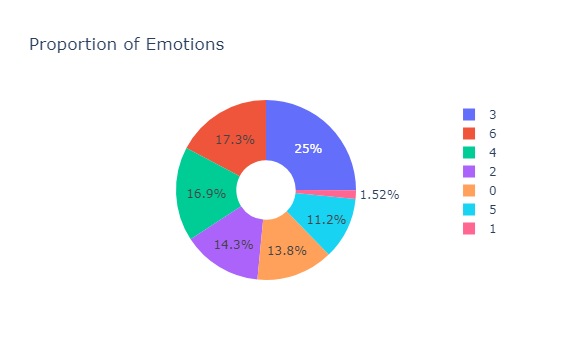

In [22]:
ex.pie(df,names='emotion', title='Proportion of Emotions',hole=0.33)

#### Data set is somewhat unbalanced, with emotion 1 sample size much smaller than other emotions.

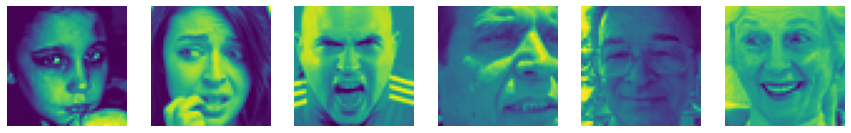

In [23]:
#sample of face images in the dataset

fig, axes = plt.subplots(1, 6, figsize=(15, 5))

for i in range (0, 6):
    k=df['pixels'][20+i]
    k=np.fromstring(k, sep=' ')
    k=k.reshape(48,48)
    k.shape
    axes[i].imshow(k, cmap='viridis');
    axes[i].axis('off')

## Feature Engineering

In [24]:
#split pixels columns into features and scale the pixel value to between 0 and 1.

pixels = df['pixels'].str.split(' ', expand=True)

pixels = pixels.astype(int)
pixels = pixels / 255.0
dff=pd.concat([df.drop(columns=['pixels']), pixels], axis=1)
dff.head(6)

,emotion,Usage,0,1,2,3,4,5,6,7,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0,Training,0.274510,0.313725,0.321569,0.282353,0.227451,0.227451,0.235294,0.247059,...,0.623529,0.713725,0.717647,0.533333,0.415686,0.454902,0.372549,0.415686,0.427451,0.321569
1,0,Training,0.592157,0.588235,0.576471,0.607843,0.580392,0.521569,0.435294,0.549020,...,0.411765,0.423529,0.372549,0.423529,0.400000,0.262745,0.670588,0.756863,0.717647,0.721569
2,2,Training,0.905882,0.831373,0.611765,0.643137,0.682353,0.541176,0.631373,0.678431,...,0.407843,0.541176,0.596078,0.478431,0.447059,0.396078,0.380392,0.345098,0.431373,0.596078
3,4,Training,0.094118,0.125490,0.141176,0.117647,0.125490,0.090196,0.074510,0.078431,...,0.682353,0.494118,0.517647,0.517647,0.521569,0.533333,0.545098,0.556863,0.560784,0.556863
4,6,Training,0.015686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.047059,0.133333,0.121569,0.121569,0.121569,0.105882,0.121569,0.117647,0.113725,0.117647
5,2,Training,0.215686,0.215686,0.215686,0.215686,0.215686,0.211765,0.235294,0.266667,...,0.352941,0.325490,0.301961,0.207843,0.145098,0.133333,0.117647,0.133333,0.117647,0.223529


In [25]:
#Split dataframes into training and test sets, then convert label to catgeory data type

train_df=dff[dff['Usage'] == 'Training'].drop('Usage', axis='columns')
public_test_df=dff[dff['Usage'].isin(['PrivateTest', 'PublicTest'])].drop('Usage', axis='columns')

train_X = train_df.drop(columns=['emotion'])
train_y = train_df[['emotion']].astype('category')

public_test_X = public_test_df.drop(columns=['emotion'])
public_test_y = public_test_df[['emotion']].astype('category')

In [26]:
display(train_X.shape)
display(public_test_X.shape)
display(train_y.shape)
display(public_test_y.shape)
display(train_y.info())
display(public_test_y.info())

(28709, 2304)

(7178, 2304)

(28709, 1)

(7178, 1)

<class 'pandas.core.frame.DataFrame'>
Index: 28709 entries, 0 to 28708
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   emotion  28709 non-null  category
dtypes: category(1)
memory usage: 252.7 KB


None

<class 'pandas.core.frame.DataFrame'>
Index: 7178 entries, 28709 to 35886
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   emotion  7178 non-null   category
dtypes: category(1)
memory usage: 63.4 KB


None

#### Our image dataset has 48 x 48 = 2304 features

## Principal Component Analysis

In [27]:
pca = PCA()

X_pca = pca.fit_transform(train_X)

220    0.943691
221    0.943910
222    0.944127
223    0.944342
224    0.944554
225    0.944765
226    0.944975
227    0.945185
228    0.945393
229    0.945599
230    0.945804
231    0.946008
232    0.946211
233    0.946413
234    0.946613
235    0.946811
236    0.947008
237    0.947205
238    0.947401
239    0.947596
240    0.947791
241    0.947983
242    0.948171
243    0.948360
244    0.948548
245    0.948735
246    0.948921
247    0.949105
248    0.949288
249    0.949470
250    0.949651
251    0.949831
252    0.950009
253    0.950186
254    0.950362
255    0.950538
256    0.950713
257    0.950887
258    0.951059
259    0.951231
260    0.951402
261    0.951572
262    0.951741
263    0.951910
264    0.952077
265    0.952244
266    0.952409
267    0.952574
268    0.952738
269    0.952900
270    0.953062
271    0.953223
272    0.953384
273    0.953544
274    0.953702
275    0.953861
276    0.954017
277    0.954172
278    0.954326
279    0.954481
dtype: float64

<Axes: >

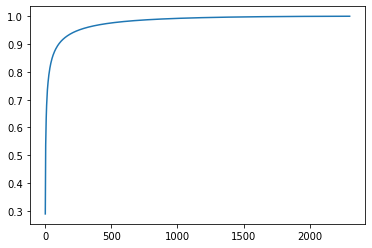

In [28]:
display(pd.Series(pca.explained_variance_ratio_.cumsum()).iloc[220:280])

display(pd.Series(pca.explained_variance_ratio_.cumsum()).plot(kind='line'));

#### Using PCA, we can see that just 253 features can explain 95% of the variance in our dataset

#### A few principal component faces

In [ ]:
k=

In [30]:
#dimensionality reduction using PCA on the training and test data

pca = PCA(n_components=253).fit(train_X)
pca_train_X = pca.transform(train_X)
pca_public_test_X = pca.transform(public_test_X)

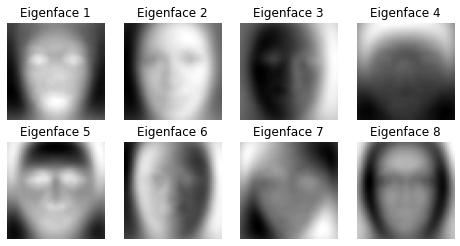

In [31]:
eigenfaces = pca.components_.reshape((253, 48, 48))
plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(eigenfaces[i], cmap='gray')
    plt.title(f'Eigenface {i + 1}')
    plt.axis('off')

In [ ]:
display(pca_train_X.shape)
display(train_y.shape)

## Machine Learning Pipeline

In [ ]:

#Machine learning pipeline

pipeline = Pipeline([
    ('clf', DecisionTreeClassifier(max_depth=30, random_state=88))
])


#### DecisionTree Classifier is choosen as basemodel because it can do multi-label classification.

In [ ]:
#train the model

pipeline.fit(pca_train_X, train_y)

#predict
y_pred = pipeline.predict(pca_public_test_X)


In [ ]:
accuracy=accuracy_score(public_test_y, y_pred)
print("accuracy: {:.2f}".format(accuracy))
precision=precision_score(public_test_y, y_pred, average="weighted")
print("precision: {:.2f}".format(precision))
recall=recall_score(public_test_y, y_pred, average="weighted")
print("recall: {:.2f}".format(recall))

print("\nClassification Report:\n", classification_report(public_test_y, y_pred, target_names=labels))

Accuracy is 29%

Random OverSampling reduces accuracy of the model.

In [ ]:
pipeline = Pipeline([
    ('ros', RandomOverSampler(random_state=88)),
    ('clf', DecisionTreeClassifier(max_depth=30, random_state=88))
])
pipeline.fit(pca_train_X, train_y)
y_pred = pipeline.predict(pca_public_test_X)

accuracy=accuracy_score(public_test_y, y_pred)
print("accuracy: {:.2f}".format(accuracy))

Accuracy is 28%

#### sklearn's SVM supports multi-label classification 

In [ ]:
pipeline = Pipeline([
    ('clf', SVC(kernel="rbf", class_weight="balanced"))
])
pipeline.fit(pca_train_X, train_y.values.ravel())
y_pred = pipeline.predict(pca_public_test_X)


In [ ]:
accuracy=accuracy_score(public_test_y, y_pred)
print("accuracy: {:.2f}".format(accuracy))
precision=precision_score(public_test_y, y_pred, average="weighted")
print("precision: {:.2f}".format(precision))
recall=recall_score(public_test_y, y_pred, average="weighted")
print("recall: {:.2f}".format(recall))

print("\nClassification Report:\n", classification_report(public_test_y, y_pred, target_names=labels))


In [ ]:
cm = confusion_matrix(public_test_y, y_pred)

cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,  xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Accuracy is 44%

#### RandomForest Classifier is another classifier that can do multi-label classification

In [ ]:

pipeline2 = Pipeline([
 
    ('clf', RandomForestClassifier(max_depth=30, random_state=88))
])

#train the model
pipeline2.fit(pca_train_X, train_y.values.ravel())

#predict
y_pred = pipeline2.predict(pca_public_test_X)

accuracy=accuracy_score(public_test_y, y_pred)
print("accuracy: {:.2f}".format(accuracy))
precision=precision_score(public_test_y, y_pred, average="weighted")
print("precision: {:.2f}".format(precision))
recall=recall_score(public_test_y, y_pred, average="weighted")
print("recall: {:.2f}".format(recall))

print("\nClassification Report:\n", classification_report(public_test_y, y_pred, target_names=labels))

In [ ]:
cm = confusion_matrix(public_test_y, y_pred)

cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,  xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Accuracy is 40%

#### SVM achieves the highest accuracy

## Hyperparameter Tunning and Cross-Validation

In [ ]:

parameters = {
    "clf__C": loguniform(1e3, 1e5),
    "clf__gamma": loguniform(1e-4, 1e-1),
}

gs = RandomizedSearchCV(pipeline, parameters, cv=3, n_iter=10, verbose=2, n_jobs=-1)

gs.fit(pca_train_X, train_y.values.ravel())

In [ ]:
print("Best model: ", gs.best_estimator_)
accuracy = gs.best_estimator_.score(pca_public_test_X, public_test_y)

print("Best hyperparameters:", gs.best_params_)
print("Best model accuracy:", accuracy)

Best hyperparameters: {'clf__C': 2086.454555964343, 'clf__gamma': 0.005837561773562714}

Best Model: SVC(C=2086.454555964343, class_weight='balanced', 
                gamma=0.005837561773562714)

Best model accuracy: 0.459.


In [ ]:
train_score = gs.score(pca_train_X, train_y.values.ravel())
cv_score = gs.best_score_

In [ ]:
display(train_score)
display(cv_score)

#### The training score is lot higher than validation score so the model is overfitting.

##
##

## Neural Network Model

In [ ]:
train_X = np.array(train_X, dtype = 'uint8')
train_y = np.array(train_y, dtype = 'uint8')
public_test_X = np.array(public_test_X, dtype = 'uint8')
public_test_y = np.array(public_test_y, dtype = 'uint8')
train_X_nn = train_X.reshape(train_X.shape[0], 48, 48, 1)
public_test_X_nn = public_test_X.reshape(public_test_X.shape[0], 48, 48, 1)

In [ ]:
#one hot encode the target labels

train_y= to_categorical(train_y, num_classes=7)
public_test_y = to_categorical(public_test_y, num_classes=7)

public_test_y.shape

In [ ]:
cnn = models.Sequential()
shape=(48, 48, 1)

#input layer
cnn.add(layers.InputLayer(input_shape=shape))

# Convolutional and Pooling Layers
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))


cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))



# Fully Connected Layers
cnn.add(layers.Flatten())
cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(7, activation='softmax'))  # Adjust the output size based on the number of classes

# Compile the model
cnn.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

cnn.summary()

In [ ]:
history = cnn.fit(train_X_nn, train_y, epochs=30, validation_data=(public_test_X_nn, public_test_y))

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss+
pyplot.tight_layout()
pyplot.show()

#### The model's accuracy on the training set is increasing, but its accuracy on the validation set is not increasing. 
#### The gap between train_loss and validate_loss is increasing means the model is overfitting.

In [ ]:
predictions = cnn.predict(public_test_X_nn)

In [ ]:
predictions=pd.DataFrame(predictions.argmax(axis=1), columns=['emotion'])

In [ ]:
print(classification_report(public_test_y, predictions, target_names=labels))

In [ ]:
cm = confusion_matrix(public_test_y, predictions)

cm_percentages = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,  xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### The neural work seems to overwhelmingly predict emotion to be "happy" which happens to be the class with the highest number of samples.

##
## Conclusion
#### Traditional machine learning algorithms like support Vector Machine achieves better result than Convolutional neural network for facial emotion recognition.
